# OCEAN Ground Truth Model Comparison

This notebook compares the quality of OCEAN personality scores generated by 5 different LLM models:
- Llama-3.1-8B
- GPT-OSS-120B
- Qwen-2.5-72B
- Gemma-2-9B
- DeepSeek-V3.1

## 1. Setup and Data Loading

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print('Libraries imported successfully')

Libraries imported successfully


In [18]:
# Model configurations
models = {
    'llama_3.1_8b': 'Llama-3.1-8B',
    'gpt_oss_120b': 'GPT-OSS-120B',
    'qwen_2.5_72b': 'Qwen-2.5-72B',
    'gemma_2_9b': 'Gemma-2-9B',
    'deepseek_v3.1': 'DeepSeek-V3.1'
}

# Cost and time data (for 500 samples)
# Note: Llama tokens/cost are N/A due to multiple retries
model_metrics = {
    'llama_3.1_8b': {'tokens': None, 'cost': None, 'time_min': 30.0},
    'gpt_oss_120b': {'tokens': 817, 'cost': 0.10, 'time_min': 42.1},
    'qwen_2.5_72b': {'tokens': 703, 'cost': 0.11, 'time_min': 70.2},
    'gemma_2_9b': {'tokens': 1030, 'cost': 0.03, 'time_min': 19.0},
    'deepseek_v3.1': {'tokens': 822, 'cost': 0.18, 'time_min': 32.5}
}

ocean_dims = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']

print(f'Total models: {len(models)}')
print(f'OCEAN dimensions: {len(ocean_dims)}')

Total models: 5
OCEAN dimensions: 5


In [19]:
# Load all OCEAN ground truth files
data = {}

for model_id, model_name in models.items():
    file_path = f'../ocean_ground_truth/{model_id}_ocean_500.csv'
    try:
        df = pd.read_csv(file_path)
        data[model_id] = {
            'name': model_name,
            'df': df
        }
        print(f'Loaded: {model_name} ({len(df)} samples)')
    except Exception as e:
        print(f'Error loading {model_name}: {str(e)}')
        data[model_id] = None

print(f'\nSuccessfully loaded {sum(1 for v in data.values() if v is not None)}/{len(models)} models')

Loaded: Llama-3.1-8B (500 samples)
Loaded: GPT-OSS-120B (500 samples)
Loaded: Qwen-2.5-72B (500 samples)
Loaded: Gemma-2-9B (500 samples)
Loaded: DeepSeek-V3.1 (500 samples)

Successfully loaded 5/5 models


## 2. Data Quality Metrics

In [20]:
# Calculate quality metrics for each model
quality_metrics = []

for model_id, model_data in data.items():
    if model_data is None:
        continue
    
    df = model_data['df']
    model_name = model_data['name']
    
    # Basic statistics
    total_samples = len(df)
    valid_samples = df[ocean_dims].notna().all(axis=1).sum()
    valid_pct = (valid_samples / total_samples) * 100
    
    # Count samples with all dimensions = 0.5
    count_all_05 = 0
    for idx, row in df.iterrows():
        if all(abs(row[dim] - 0.5) < 0.01 for dim in ocean_dims if pd.notna(row[dim])):
            count_all_05 += 1
    
    all_05_pct = (count_all_05 / total_samples) * 100
    
    # Calculate average standard deviation
    avg_std = np.mean([df[dim].std() for dim in ocean_dims])
    
    # Get time metrics
    time_min = model_metrics[model_id]['time_min']
    time_per_sample_sec = (time_min * 60) / total_samples if time_min else None
    
    quality_metrics.append({
        'Model': model_name,
        'Total Samples': total_samples,
        'Valid Samples': valid_samples,
        'Valid Percentage': valid_pct,
        'All=0.5 Count': count_all_05,
        'All=0.5 Percentage': all_05_pct,
        'Average Std Dev': avg_std,
        'Processing Time (min)': time_min,
        'Time per Sample (sec)': time_per_sample_sec
    })

df_quality = pd.DataFrame(quality_metrics)
print('Data Quality Summary:')
print(df_quality.to_string(index=False))

Data Quality Summary:
        Model  Total Samples  Valid Samples  Valid Percentage  All=0.5 Count  All=0.5 Percentage  Average Std Dev  Processing Time (min)  Time per Sample (sec)
 Llama-3.1-8B            500            490              98.0             10                 2.0         0.144228                   30.0                  3.600
 GPT-OSS-120B            500            500             100.0              5                 1.0         0.125561                   42.1                  5.052
 Qwen-2.5-72B            500            495              99.0              7                 1.4         0.106472                   70.2                  8.424
   Gemma-2-9B            500            500             100.0              0                 0.0         0.107416                   19.0                  2.280
DeepSeek-V3.1            500            500             100.0              0                 0.0         0.129408                   32.5                  3.900


In [21]:
# Calculate cost metrics for each model
cost_metrics = []

for model_id, model_data in data.items():
    if model_data is None:
        continue
    
    model_name = model_data['name']
    total_samples = len(model_data['df'])
    
    # Get cost data
    tokens = model_metrics[model_id]['tokens']
    cost = model_metrics[model_id]['cost']
    
    # Calculate per-sample metrics
    if tokens is not None and cost is not None:
        avg_tokens = tokens / total_samples
        avg_cost = cost / total_samples
        tokens_str = f'{tokens:,}'
        cost_str = f'${cost:.4f}'
        avg_tokens_str = f'{avg_tokens:.2f}'
        avg_cost_str = f'${avg_cost:.6f}'
    else:
        tokens_str = 'N/A*'
        cost_str = 'N/A*'
        avg_tokens_str = 'N/A*'
        avg_cost_str = 'N/A*'
    
    cost_metrics.append({
        'Model': model_name,
        'Total Tokens': tokens_str,
        'Total Cost': cost_str,
        'Avg Tokens/Sample': avg_tokens_str,
        'Avg Cost/Sample': avg_cost_str
    })

df_cost = pd.DataFrame(cost_metrics)
print('\nCost Metrics Summary:')
print(df_cost.to_string(index=False))
print('\n* Llama-3.1-8B: Total metrics N/A due to multiple retries during generation')


Cost Metrics Summary:
        Model Total Tokens Total Cost Avg Tokens/Sample Avg Cost/Sample
 Llama-3.1-8B         N/A*       N/A*              N/A*            N/A*
 GPT-OSS-120B          817    $0.1000              1.63       $0.000200
 Qwen-2.5-72B          703    $0.1100              1.41       $0.000220
   Gemma-2-9B        1,030    $0.0300              2.06       $0.000060
DeepSeek-V3.1          822    $0.1800              1.64       $0.000360

* Llama-3.1-8B: Total metrics N/A due to multiple retries during generation


## 3. Statistical Analysis Per Dimension

In [22]:
# Calculate statistics for each OCEAN dimension per model
for model_id, model_data in data.items():
    if model_data is None:
        continue
    
    df = model_data['df']
    model_name = model_data['name']
    
    print(f'\n{"=" * 80}')
    print(f'{model_name}')
    print(f'{"=" * 80}')
    
    stats_data = []
    for dim in ocean_dims:
        valid_values = df[dim].dropna()
        if len(valid_values) > 0:
            stats_data.append({
                'Dimension': dim.capitalize(),
                'Mean': f'{valid_values.mean():.3f}',
                'Std': f'{valid_values.std():.3f}',
                'Min': f'{valid_values.min():.3f}',
                'Max': f'{valid_values.max():.3f}',
                'Count=0.5': (abs(valid_values - 0.5) < 0.01).sum()
            })
    
    df_stats = pd.DataFrame(stats_data)
    print(df_stats.to_string(index=False))


Llama-3.1-8B
        Dimension  Mean   Std   Min   Max  Count=0.5
         Openness 0.343 0.110 0.000 0.800         42
Conscientiousness 0.577 0.156 0.000 0.900         76
     Extraversion 0.257 0.114 0.000 0.800          6
    Agreeableness 0.605 0.154 0.000 0.900         63
      Neuroticism 0.184 0.187 0.000 0.900         12

GPT-OSS-120B
        Dimension  Mean   Std   Min   Max  Count=0.5
         Openness 0.265 0.125 0.100 0.810          5
Conscientiousness 0.729 0.107 0.300 0.900         13
     Extraversion 0.185 0.089 0.050 0.660          5
    Agreeableness 0.419 0.141 0.100 0.850         29
      Neuroticism 0.331 0.165 0.050 0.850         22

Qwen-2.5-72B
        Dimension  Mean   Std   Min   Max  Count=0.5
         Openness 0.338 0.082 0.200 0.800         15
Conscientiousness 0.690 0.131 0.300 0.900         36
     Extraversion 0.401 0.072 0.200 0.900         91
    Agreeableness 0.595 0.096 0.400 0.900        166
      Neuroticism 0.474 0.152 0.200 0.800        152

Gem

## 4. Visualizations

### 4.1 Valid Sample Percentage Comparison

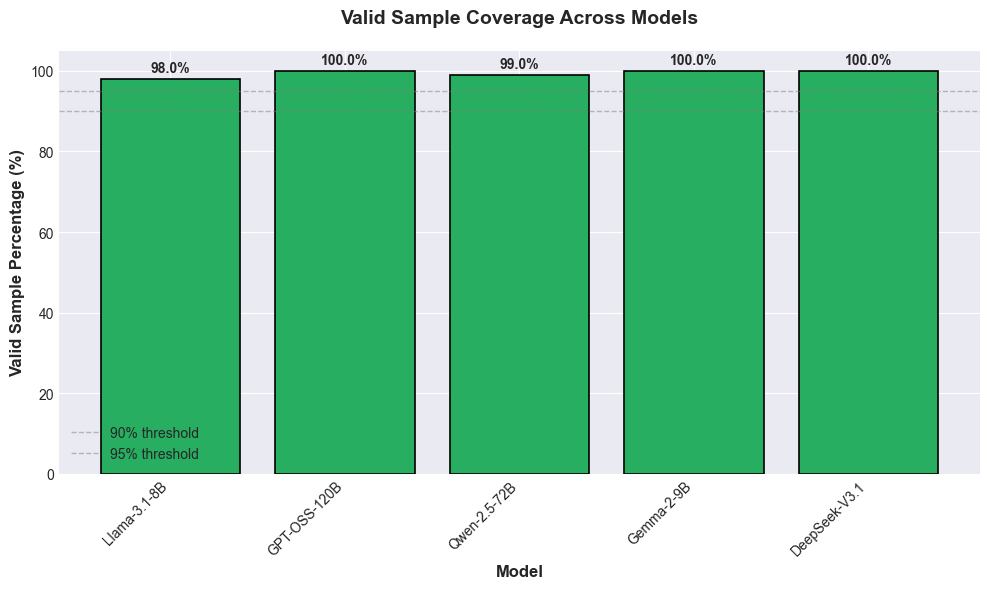

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

models_list = df_quality['Model'].tolist()
valid_pcts = df_quality['Valid Percentage'].tolist()

colors = ['#e74c3c' if pct < 90 else '#f39c12' if pct < 95 else '#27ae60' for pct in valid_pcts]

bars = ax.bar(models_list, valid_pcts, color=colors, edgecolor='black', linewidth=1.2)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Valid Sample Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Valid Sample Coverage Across Models', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim([0, 105])
ax.axhline(y=90, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='90% threshold')
ax.axhline(y=95, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='95% threshold')
ax.legend()

for bar, pct in zip(bars, valid_pcts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4.2 Default Value (0.5) Percentage Comparison

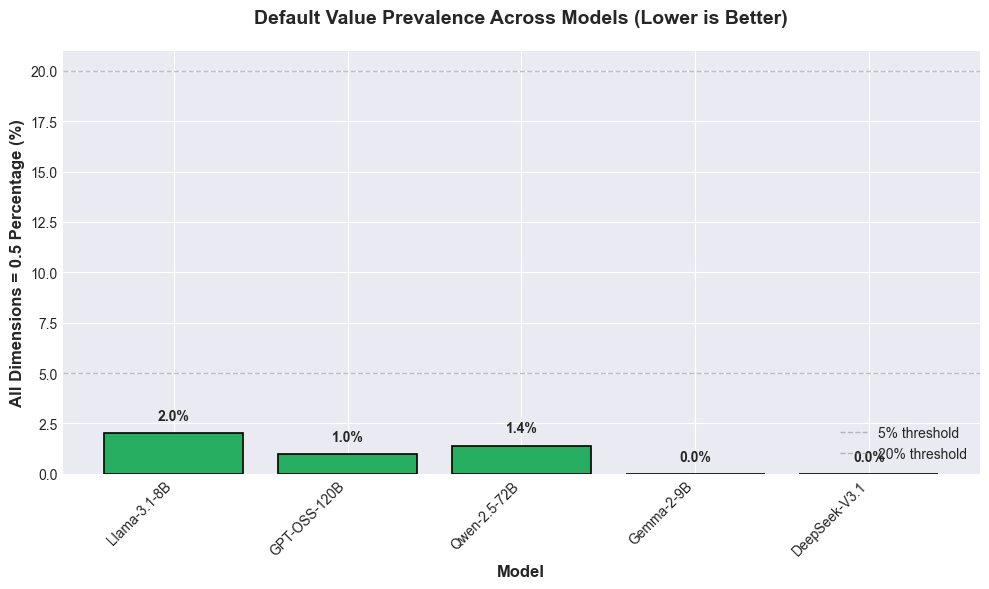

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

default_pcts = df_quality['All=0.5 Percentage'].tolist()

colors = ['#27ae60' if pct < 5 else '#f39c12' if pct < 20 else '#e74c3c' for pct in default_pcts]

bars = ax.bar(models_list, default_pcts, color=colors, edgecolor='black', linewidth=1.2)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('All Dimensions = 0.5 Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Default Value Prevalence Across Models (Lower is Better)', fontsize=14, fontweight='bold', pad=20)
ax.axhline(y=5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='5% threshold')
ax.axhline(y=20, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='20% threshold')
ax.legend()

for bar, pct in zip(bars, default_pcts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4.3 Distribution of OCEAN Dimensions by Model

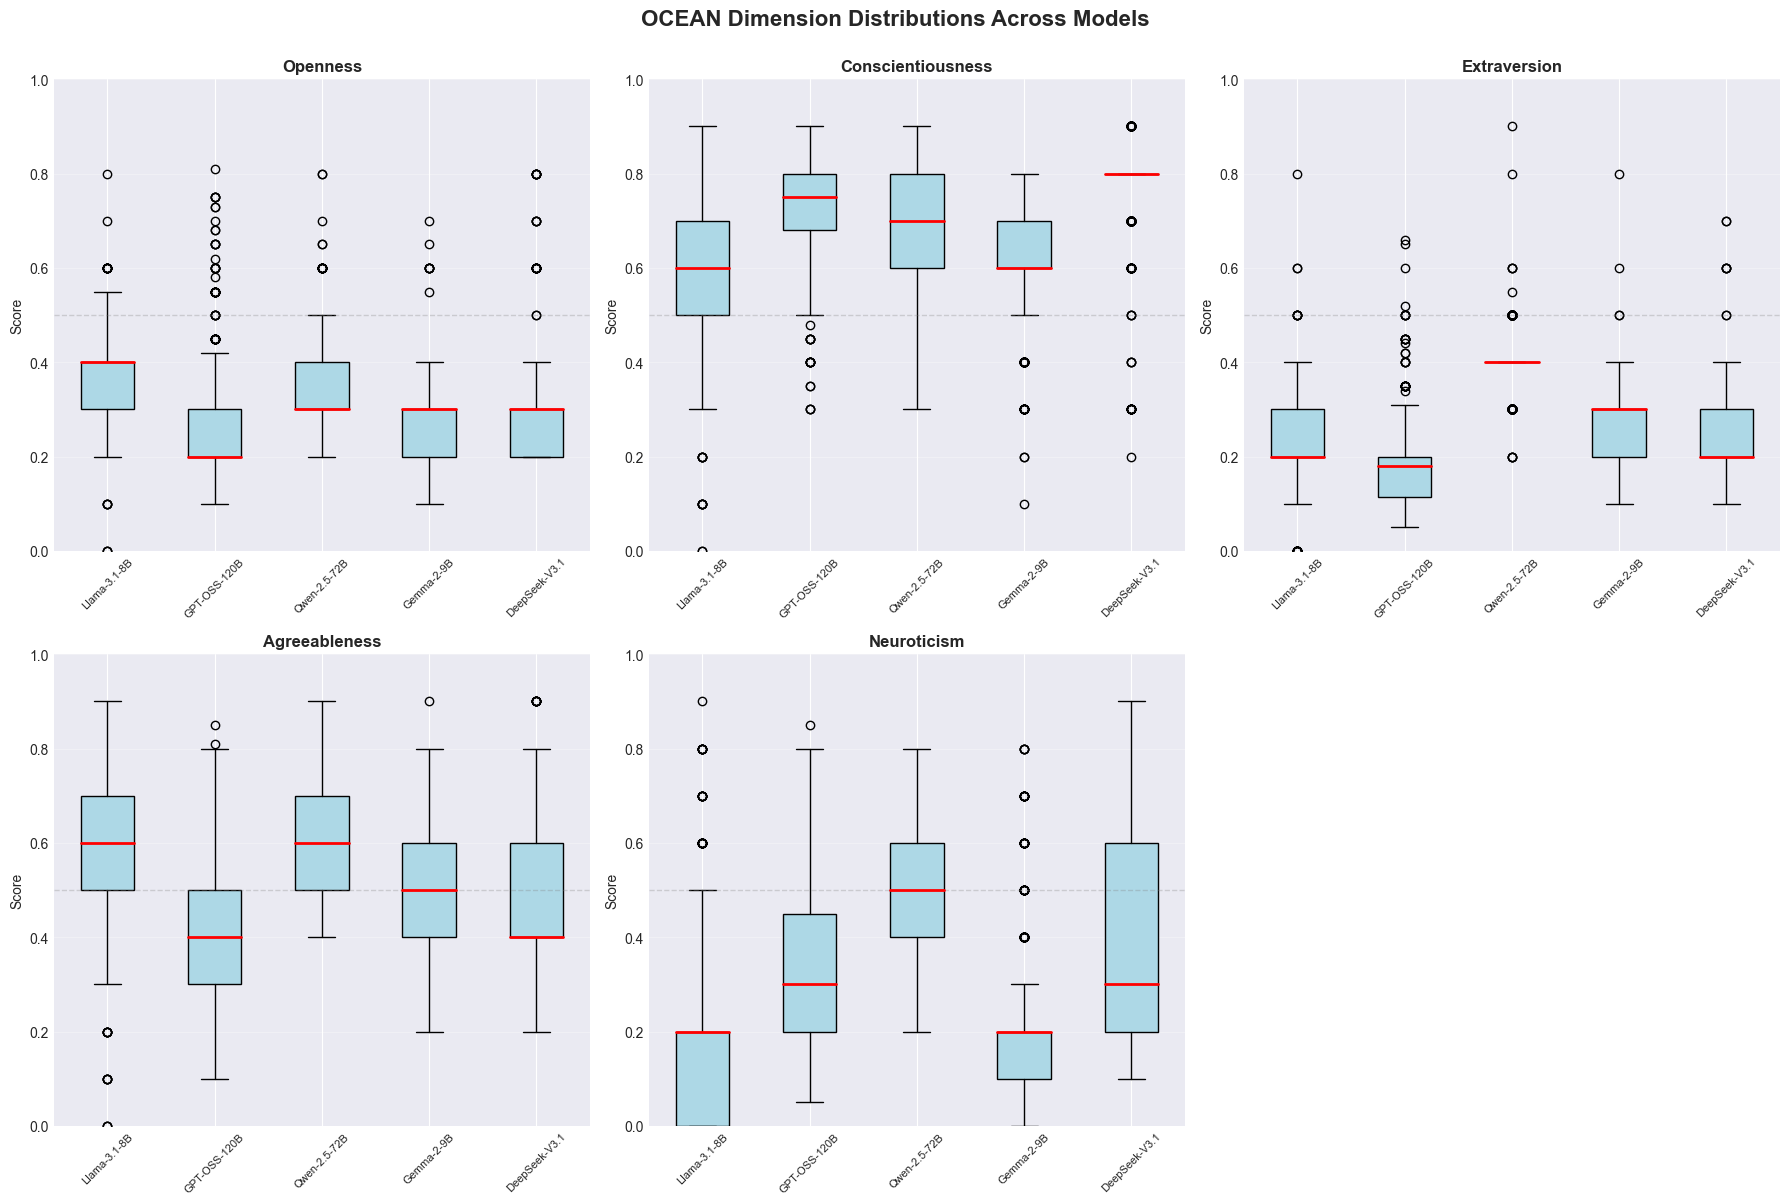

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, dim in enumerate(ocean_dims):
    ax = axes[idx]
    
    box_data = []
    labels = []
    
    for model_id, model_data in data.items():
        if model_data is None:
            continue
        df = model_data['df']
        valid_values = df[dim].dropna()
        if len(valid_values) > 0:
            box_data.append(valid_values)
            labels.append(model_data['name'])
    
    bp = ax.boxplot(box_data, labels=labels, patch_artist=True, 
                     boxprops=dict(facecolor='lightblue', edgecolor='black'),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'))
    
    ax.set_title(f'{dim.capitalize()}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('OCEAN Dimension Distributions Across Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 4.4 Heatmap: Mean Scores Across Models

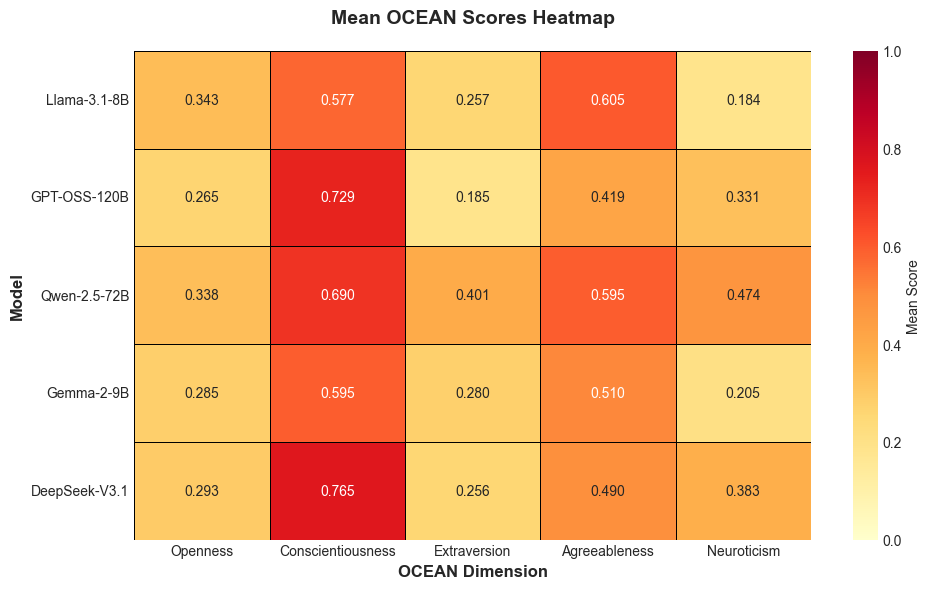

In [26]:
# Create mean scores matrix
mean_scores = []
model_names = []

for model_id, model_data in data.items():
    if model_data is None:
        continue
    df = model_data['df']
    model_names.append(model_data['name'])
    means = [df[dim].mean() for dim in ocean_dims]
    mean_scores.append(means)

mean_scores_df = pd.DataFrame(mean_scores, 
                               index=model_names,
                               columns=[d.capitalize() for d in ocean_dims])

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(mean_scores_df, annot=True, fmt='.3f', cmap='YlOrRd', 
            linewidths=0.5, linecolor='black', cbar_kws={'label': 'Mean Score'},
            vmin=0, vmax=1, ax=ax)

ax.set_title('Mean OCEAN Scores Heatmap', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('OCEAN Dimension', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.5 Standard Deviation Comparison

### 4.6 Processing Time Comparison

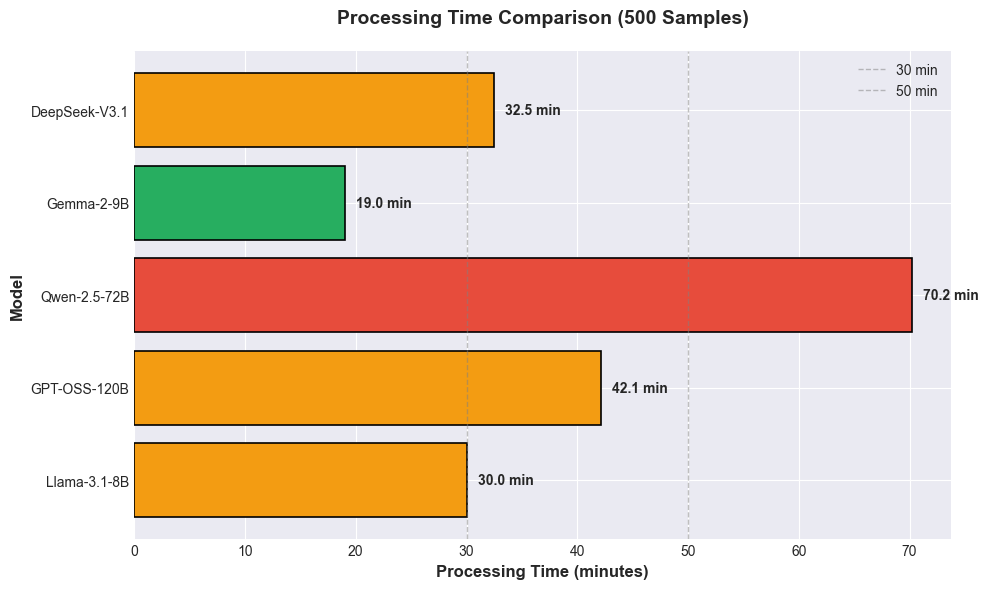


Time Efficiency (samples per minute):
Llama-3.1-8B        : 16.67 samples/min
GPT-OSS-120B        : 11.88 samples/min
Qwen-2.5-72B        : 7.12 samples/min
Gemma-2-9B          : 26.32 samples/min
DeepSeek-V3.1       : 15.38 samples/min


In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

# Get processing times
processing_times = df_quality['Processing Time (min)'].tolist()
models_list = df_quality['Model'].tolist()

# Color code: faster is better (green), slower is worse (red)
colors = ['#27ae60' if t < 30 else '#f39c12' if t < 50 else '#e74c3c' for t in processing_times]

bars = ax.barh(models_list, processing_times, color=colors, edgecolor='black', linewidth=1.2)

ax.set_xlabel('Processing Time (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Processing Time Comparison (500 Samples)', fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=30, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='30 min')
ax.axvline(x=50, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50 min')
ax.legend()

# Add value labels
for bar, time_val in zip(bars, processing_times):
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2., 
            f'{time_val:.1f} min', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Show time efficiency
print('\nTime Efficiency (samples per minute):')
for model, time_min in zip(models_list, processing_times):
    samples_per_min = 500 / time_min
    print(f'{model:20s}: {samples_per_min:.2f} samples/min')

### 4.7 Average Cost per Sample Comparison

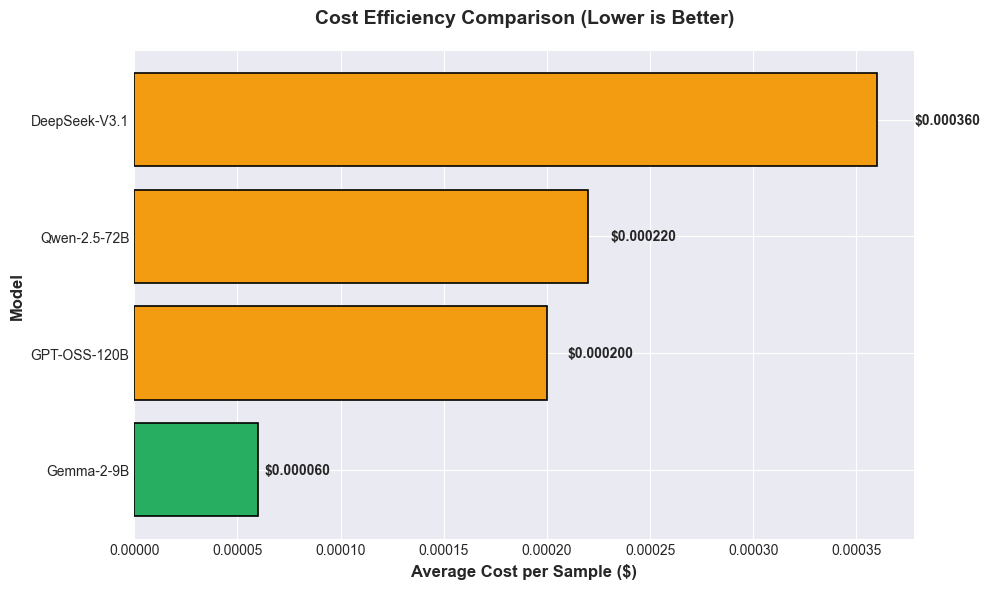


Cost Summary:
Gemma-2-9B          : $0.000060 per sample
GPT-OSS-120B        : $0.000200 per sample
Qwen-2.5-72B        : $0.000220 per sample
DeepSeek-V3.1       : $0.000360 per sample

* Note: Llama-3.1-8B excluded due to unreliable total cost data


In [28]:
# Prepare cost data for visualization (including Llama with estimated avg cost)
cost_viz_data = []

for model_id in models.keys():
    model_name = models[model_id]
    tokens = model_metrics[model_id]['tokens']
    cost = model_metrics[model_id]['cost']
    
    if tokens is not None and cost is not None:
        avg_cost = cost / 500  # 500 samples
        cost_viz_data.append({'Model': model_name, 'Avg Cost': avg_cost, 'has_data': True})

# Sort by cost
cost_viz_data = sorted(cost_viz_data, key=lambda x: x['Avg Cost'])

fig, ax = plt.subplots(figsize=(10, 6))

models_for_cost = [d['Model'] for d in cost_viz_data]
avg_costs = [d['Avg Cost'] for d in cost_viz_data]

# Color code: cheaper is better (green), expensive is worse (red)
colors = ['#27ae60' if c < 0.0002 else '#f39c12' if c < 0.0004 else '#e74c3c' for c in avg_costs]

bars = ax.barh(models_for_cost, avg_costs, color=colors, edgecolor='black', linewidth=1.2)

ax.set_xlabel('Average Cost per Sample ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Cost Efficiency Comparison (Lower is Better)', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for bar, cost_val in zip(bars, avg_costs):
    width = bar.get_width()
    ax.text(width + width*0.05, bar.get_y() + bar.get_height()/2., 
            f'${cost_val:.6f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print cost summary
print('\nCost Summary:')
print('=' * 60)
for item in cost_viz_data:
    print(f'{item["Model"]:20s}: ${item["Avg Cost"]:.6f} per sample')
print('\n* Note: Llama-3.1-8B excluded due to unreliable total cost data')

### 4.8 Time vs Quality Trade-off Analysis

KeyError: 'Quality Score'

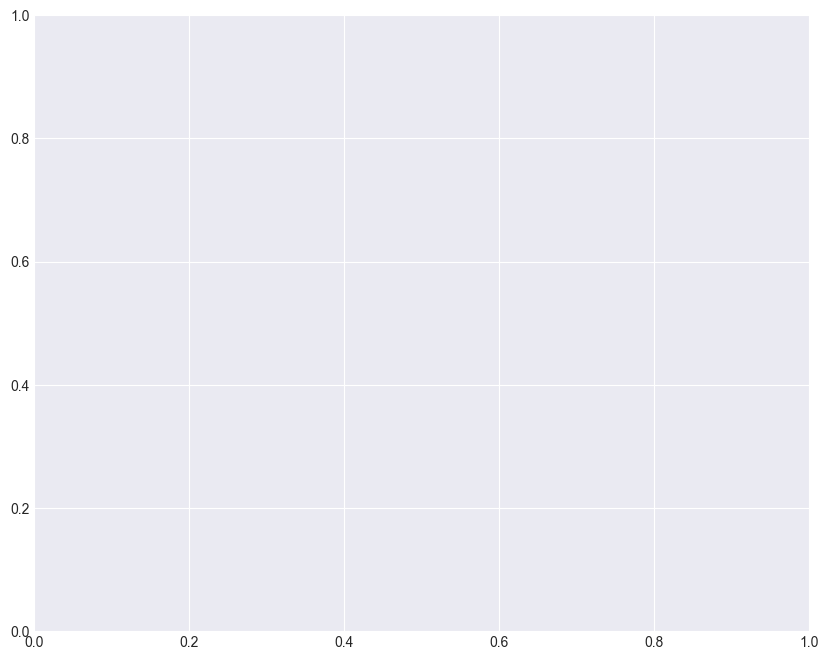

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))

# Prepare data for scatter plot
times = df_quality['Processing Time (min)'].tolist()
quality_scores = df_quality['Quality Score'].tolist()
models_scatter = df_quality['Model'].tolist()

# Create scatter plot with different colors for each model
colors_scatter = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for i, (model, time, score) in enumerate(zip(models_scatter, times, quality_scores)):
    ax.scatter(time, score, s=300, color=colors_scatter[i], alpha=0.6, 
               edgecolors='black', linewidth=2, label=model, zorder=3)
    # Add model label next to point
    ax.annotate(model, (time, score), xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold')

ax.set_xlabel('Processing Time (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('Quality Score', fontsize=12, fontweight='bold')
ax.set_title('Time vs Quality Trade-off\n(Top-right is ideal: High quality, Low time)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Add quadrant lines at median values
median_time = np.median(times)
median_quality = np.median(quality_scores)
ax.axvline(x=median_time, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(y=median_quality, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Add quadrant labels
ax.text(median_time * 0.5, max(quality_scores) * 0.98, 'Fast & High Quality', 
        ha='center', va='top', fontsize=10, style='italic', color='green', fontweight='bold')
ax.text(max(times) * 0.85, max(quality_scores) * 0.98, 'Slow & High Quality', 
        ha='center', va='top', fontsize=10, style='italic', color='orange')

plt.tight_layout()
plt.show()

# Calculate efficiency metrics
print('\nTime-Quality Efficiency Metrics:')
print('=' * 70)
for model, time, score in zip(models_scatter, times, quality_scores):
    efficiency = score / time  # Quality per minute
    print(f'{model:20s}: {efficiency:.2f} quality points per minute')

### 4.9 Overall Value Analysis: Quality per Dollar

In [30]:
# Calculate value metrics (quality per dollar) - excluding Llama
value_data = []

for model_id in models.keys():
    model_name = models[model_id]
    
    # Get quality score for this model
    model_quality = df_quality[df_quality['Model'] == model_name]['Quality Score'].values
    
    if len(model_quality) > 0:
        quality_score = model_quality[0]
        
        # Get cost data
        tokens = model_metrics[model_id]['tokens']
        cost = model_metrics[model_id]['cost']
        
        if tokens is not None and cost is not None:
            value_score = quality_score / cost  # Quality points per dollar
            value_data.append({
                'Model': model_name,
                'Quality Score': quality_score,
                'Total Cost': cost,
                'Value Score': value_score
            })

# Sort by value score
value_data = sorted(value_data, key=lambda x: x['Value Score'], reverse=True)

fig, ax = plt.subplots(figsize=(10, 6))

models_value = [d['Model'] for d in value_data]
value_scores = [d['Value Score'] for d in value_data]

# Color code: higher value is better
colors = ['#27ae60' if v > 1000 else '#f39c12' if v > 500 else '#e74c3c' for v in value_scores]

bars = ax.barh(models_value, value_scores, color=colors, edgecolor='black', linewidth=1.2)

ax.set_xlabel('Value Score (Quality Points per Dollar)', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Overall Value: Quality per Dollar Spent (Higher is Better)', 
             fontsize=14, fontweight='bold', pad=20)

# Add value labels
for bar, val in zip(bars, value_scores):
    width = bar.get_width()
    ax.text(width + width*0.03, bar.get_y() + bar.get_height()/2., 
            f'{val:.1f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print comprehensive value analysis
print('\nComprehensive Value Analysis:')
print('=' * 90)
print(f'{"Model":<20} {"Quality":<12} {"Cost":<12} {"Value Score":<15} {"Rank"}')
print('=' * 90)
for idx, item in enumerate(value_data, 1):
    print(f'{item["Model"]:<20} {item["Quality Score"]:<12.2f} '
          f'${item["Total Cost"]:<11.4f} {item["Value Score"]:<15.1f} #{idx}')
print('=' * 90)
print('\n* Note: Llama-3.1-8B excluded due to unreliable cost data')
print('* Value Score = Quality Score / Total Cost (500 samples)')
print('* Higher value score means better quality-to-cost ratio')

KeyError: 'Quality Score'

In [ ]:
# Create standard deviation matrix
std_scores = []

for model_id, model_data in data.items():
    if model_data is None:
        continue
    df = model_data['df']
    stds = [df[dim].std() for dim in ocean_dims]
    std_scores.append(stds)

std_scores_df = pd.DataFrame(std_scores, 
                              index=model_names,
                              columns=[d.capitalize() for d in ocean_dims])

fig, ax = plt.subplots(figsize=(10, 6))
std_scores_df.T.plot(kind='bar', ax=ax, width=0.8)

ax.set_title('Standard Deviation by OCEAN Dimension and Model', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('OCEAN Dimension', fontsize=12, fontweight='bold')
ax.set_ylabel('Standard Deviation', fontsize=12, fontweight='bold')
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Comparative Summary and Ranking

In [ ]:
# Calculate composite quality score
df_quality['Quality Score'] = (
    df_quality['Valid Percentage'] * 0.3 + 
    (100 - df_quality['All=0.5 Percentage']) * 0.4 + 
    df_quality['Average Std Dev'] * 100 * 0.3
)

# Sort by quality score
df_quality_sorted = df_quality.sort_values('Quality Score', ascending=False).reset_index(drop=True)

print('\n' + '='*100)
print('MODEL RANKINGS ACROSS MULTIPLE DIMENSIONS')
print('='*100)

# 1. Quality Ranking
print('\n1. QUALITY RANKING (Data Quality Only):')
print('=' * 100)
for idx, row in df_quality_sorted.iterrows():
    print(f"Rank {idx+1}: {row['Model']}")
    print(f"  Valid Rate: {row['Valid Percentage']:.1f}%")
    print(f"  Default Rate: {row['All=0.5 Percentage']:.1f}%")
    print(f"  Avg Std Dev: {row['Average Std Dev']:.3f}")
    print(f"  Quality Score: {row['Quality Score']:.2f}")
    print()

# 2. Speed Ranking (Time Efficiency)
print('\n2. SPEED RANKING (Fastest Processing):')
print('=' * 100)
df_time_sorted = df_quality.sort_values('Processing Time (min)', ascending=True).reset_index(drop=True)
for idx, row in df_time_sorted.iterrows():
    print(f"Rank {idx+1}: {row['Model']:<20} - {row['Processing Time (min)']:.1f} min "
          f"({500/row['Processing Time (min)']:.2f} samples/min)")

# 3. Cost Efficiency Ranking
print('\n\n3. COST EFFICIENCY RANKING (Lowest Cost):')
print('=' * 100)
# Build cost ranking data
cost_ranking = []
for model_id in models.keys():
    model_name = models[model_id]
    cost = model_metrics[model_id]['cost']
    if cost is not None:
        model_row = df_quality[df_quality['Model'] == model_name].iloc[0]
        cost_ranking.append({
            'Model': model_name,
            'Total Cost': cost,
            'Avg Cost per Sample': cost / 500,
            'Quality Score': model_row['Quality Score']
        })

cost_ranking_df = pd.DataFrame(cost_ranking).sort_values('Total Cost', ascending=True)
for idx, row in cost_ranking_df.iterrows():
    print(f"Rank {list(cost_ranking_df.index).index(idx)+1}: {row['Model']:<20} - "
          f"Total: ${row['Total Cost']:.4f}, Per Sample: ${row['Avg Cost per Sample']:.6f}")
print("\n* Note: Llama-3.1-8B excluded due to unreliable cost data")

# 4. Value Ranking (Quality per Dollar)
print('\n\n4. VALUE RANKING (Best Quality-to-Cost Ratio):')
print('=' * 100)
if len(value_data) > 0:
    for idx, item in enumerate(value_data, 1):
        print(f"Rank {idx}: {item['Model']:<20} - Value Score: {item['Value Score']:.1f} "
              f"(Quality: {item['Quality Score']:.2f} / Cost: ${item['Total Cost']:.4f})")
print("\n* Note: Llama-3.1-8B excluded due to unreliable cost data")

# 5. Time Efficiency Ranking (Quality per Minute)
print('\n\n5. TIME EFFICIENCY RANKING (Quality per Minute):')
print('=' * 100)
df_quality['Time Efficiency'] = df_quality['Quality Score'] / df_quality['Processing Time (min)']
df_time_eff_sorted = df_quality.sort_values('Time Efficiency', ascending=False).reset_index(drop=True)
for idx, row in df_time_eff_sorted.iterrows():
    print(f"Rank {idx+1}: {row['Model']:<20} - {row['Time Efficiency']:.2f} quality pts/min "
          f"({row['Quality Score']:.2f} / {row['Processing Time (min)']:.1f} min)")

print('\n' + '='*100)
print('SUMMARY: Choose based on your priorities')
print('='*100)
print(f"  Best Quality:        {df_quality_sorted.iloc[0]['Model']}")
print(f"  Fastest Processing:  {df_time_sorted.iloc[0]['Model']}")
if len(cost_ranking_df) > 0:
    print(f"  Lowest Cost:         {cost_ranking_df.iloc[0]['Model']}")
if len(value_data) > 0:
    print(f"  Best Value:          {value_data[0]['Model']}")
print(f"  Most Time-Efficient: {df_time_eff_sorted.iloc[0]['Model']}")
print('='*100)

## 6. Recommendations

In [ ]:
print('\n' + '='*100)
print('MODEL SELECTION RECOMMENDATIONS')
print('='*100)

# Get the top models from different rankings
best_quality_model = df_quality_sorted.iloc[0]
fastest_model = df_time_sorted.iloc[0]
best_time_eff_model = df_time_eff_sorted.iloc[0]

print('\n1. RECOMMENDED FOR QUALITY (Best Data Quality):')
print('='*100)
print(f'MODEL: {best_quality_model["Model"]}')
print(f'  - Quality Score: {best_quality_model["Quality Score"]:.2f}')
print(f'  - Valid Rate: {best_quality_model["Valid Percentage"]:.1f}%')
print(f'  - Non-default Scores: {100 - best_quality_model["All=0.5 Percentage"]:.1f}%')
print(f'  - Average Std Dev: {best_quality_model["Average Std Dev"]:.3f}')
print(f'  - Processing Time: {best_quality_model["Processing Time (min)"]:.1f} minutes')
print()
print('Best for:')
print('  • Research and analysis where data quality is paramount')
print('  • Creating ground truth datasets for model training')
print('  • When you need the most reliable OCEAN personality assessments')

print('\n\n2. RECOMMENDED FOR SPEED (Fastest Processing):')
print('='*100)
print(f'MODEL: {fastest_model["Model"]}')
print(f'  - Processing Time: {fastest_model["Processing Time (min)"]:.1f} minutes')
print(f'  - Throughput: {500/fastest_model["Processing Time (min)"]:.2f} samples/min')
print(f'  - Quality Score: {fastest_model["Quality Score"]:.2f}')
print()
print('Best for:')
print('  • Real-time or near-real-time applications')
print('  • Processing large volumes of data quickly')
print('  • Time-sensitive production environments')

if len(value_data) > 0:
    best_value_model_name = value_data[0]['Model']
    best_value_quality = value_data[0]['Quality Score']
    best_value_cost = value_data[0]['Total Cost']
    best_value_score = value_data[0]['Value Score']
    
    print('\n\n3. RECOMMENDED FOR VALUE (Best Quality-to-Cost Ratio):')
    print('='*100)
    print(f'MODEL: {best_value_model_name}')
    print(f'  - Value Score: {best_value_score:.1f} quality pts/$')
    print(f'  - Quality Score: {best_value_quality:.2f}')
    print(f'  - Total Cost (500 samples): ${best_value_cost:.4f}')
    print(f'  - Cost per Sample: ${best_value_cost/500:.6f}')
    print()
    print('Best for:')
    print('  • Budget-conscious projects')
    print('  • Large-scale deployments where cost adds up')
    print('  • Balancing quality with budget constraints')

print('\n\n4. RECOMMENDED FOR EFFICIENCY (Best Time-Quality Balance):')
print('='*100)
print(f'MODEL: {best_time_eff_model["Model"]}')
print(f'  - Time Efficiency: {best_time_eff_model["Time Efficiency"]:.2f} quality pts/min')
print(f'  - Quality Score: {best_time_eff_model["Quality Score"]:.2f}')
print(f'  - Processing Time: {best_time_eff_model["Processing Time (min)"]:.1f} minutes')
print()
print('Best for:')
print('  • Production systems needing good quality without long waits')
print('  • Balanced approach between quality and speed')
print('  • Most practical applications with moderate requirements')

print('\n\n5. SCENARIO-BASED RECOMMENDATIONS:')
print('='*100)
print('\nScenario A: Academic Research / Ground Truth Generation')
print(f'  → Recommendation: {best_quality_model["Model"]}')
print('  → Reason: Highest data quality is critical for reliable research')
print()
print('\nScenario B: Production API with High Volume')
if len(value_data) > 0:
    print(f'  → Recommendation: {best_value_model_name}')
    print('  → Reason: Best balance of cost and quality for scale')
print()
print('\nScenario C: Real-time User-Facing Application')
print(f'  → Recommendation: {fastest_model["Model"]}')
print('  → Reason: Speed is critical for user experience')
print()
print('\nScenario D: Prototype/MVP Development')
if len(cost_ranking_df) > 0:
    cheapest_model = cost_ranking_df.iloc[0]['Model']
    print(f'  → Recommendation: {cheapest_model}')
    print('  → Reason: Minimize costs while testing viability')

print('\n\n' + '='*100)
print('NEXT STEPS:')
print('='*100)
print('1. Select model based on your specific requirements (quality/speed/cost)')
print('2. Use selected model to generate OCEAN features for full dataset')
print('3. Train XGBoost model with OCEAN personality features')
print('4. Evaluate impact on loan default prediction performance')
print('5. Consider A/B testing if choosing between top 2-3 models')
print('='*100)

## 7. Export Summary

In [ ]:
# Create comprehensive export dataframe with all metrics
export_data = []

for model_id in models.keys():
    model_name = models[model_id]
    
    # Get quality metrics
    model_quality_row = df_quality[df_quality['Model'] == model_name]
    if len(model_quality_row) == 0:
        continue
    
    model_quality_row = model_quality_row.iloc[0]
    
    # Get cost metrics
    tokens = model_metrics[model_id]['tokens']
    cost = model_metrics[model_id]['cost']
    time_min = model_metrics[model_id]['time_min']
    
    # Calculate derived metrics
    if tokens is not None and cost is not None:
        avg_tokens = tokens / 500
        avg_cost = cost / 500
        value_score = model_quality_row['Quality Score'] / cost
    else:
        avg_tokens = None
        avg_cost = None
        value_score = None
    
    time_efficiency = model_quality_row['Quality Score'] / time_min if time_min else None
    
    export_data.append({
        'Model': model_name,
        'Quality Score': model_quality_row['Quality Score'],
        'Valid Percentage': model_quality_row['Valid Percentage'],
        'Default Value Percentage': model_quality_row['All=0.5 Percentage'],
        'Average Std Dev': model_quality_row['Average Std Dev'],
        'Processing Time (min)': time_min,
        'Time per Sample (sec)': model_quality_row['Time per Sample (sec)'],
        'Total Tokens': tokens if tokens is not None else 'N/A',
        'Total Cost ($)': cost if cost is not None else 'N/A',
        'Avg Tokens per Sample': avg_tokens if avg_tokens is not None else 'N/A',
        'Avg Cost per Sample ($)': avg_cost if avg_cost is not None else 'N/A',
        'Value Score (Quality/$)': value_score if value_score is not None else 'N/A',
        'Time Efficiency (Quality/min)': time_efficiency if time_efficiency is not None else 'N/A'
    })

df_export = pd.DataFrame(export_data)

# Sort by quality score for export
df_export_sorted = df_export.sort_values('Quality Score', ascending=False)

# Save comprehensive summary
output_file = '../ocean_ground_truth/model_comparison_summary.csv'
df_export_sorted.to_csv(output_file, index=False)
print(f'Comprehensive summary saved to: {output_file}')
print()
print('Exported columns:')
for idx, col in enumerate(df_export_sorted.columns, 1):
    print(f'  {idx}. {col}')

# Also save rankings
rankings_file = '../ocean_ground_truth/model_rankings.csv'
rankings_data = []

# Quality ranking
for idx, row in df_quality_sorted.iterrows():
    rankings_data.append({
        'Ranking Type': 'Quality',
        'Rank': idx + 1,
        'Model': row['Model'],
        'Score/Metric': row['Quality Score']
    })

# Speed ranking
for idx, row in df_time_sorted.iterrows():
    rankings_data.append({
        'Ranking Type': 'Speed',
        'Rank': idx + 1,
        'Model': row['Model'],
        'Score/Metric': row['Processing Time (min)']
    })

# Time efficiency ranking
for idx, row in df_time_eff_sorted.iterrows():
    rankings_data.append({
        'Ranking Type': 'Time Efficiency',
        'Rank': idx + 1,
        'Model': row['Model'],
        'Score/Metric': row['Time Efficiency']
    })

# Cost ranking
if len(cost_ranking_df) > 0:
    for idx, row in cost_ranking_df.iterrows():
        rankings_data.append({
            'Ranking Type': 'Cost',
            'Rank': list(cost_ranking_df.index).index(idx) + 1,
            'Model': row['Model'],
            'Score/Metric': row['Total Cost']
        })

# Value ranking
if len(value_data) > 0:
    for idx, item in enumerate(value_data, 1):
        rankings_data.append({
            'Ranking Type': 'Value',
            'Rank': idx,
            'Model': item['Model'],
            'Score/Metric': item['Value Score']
        })

df_rankings = pd.DataFrame(rankings_data)
df_rankings.to_csv(rankings_file, index=False)
print(f'\nRankings saved to: {rankings_file}')

print()
print('='*80)
print('ANALYSIS COMPLETE!')
print('='*80)
print('\nFiles generated:')
print(f'  1. {output_file}')
print(f'     - Comprehensive model comparison with all metrics')
print(f'  2. {rankings_file}')
print(f'     - Model rankings across different dimensions')
print()
print('You can now:')
print('  • Review the exported CSVs for detailed analysis')
print('  • Share results with your team')
print('  • Use rankings to make informed model selection decisions')
print('='*80)